In [ ]:
######################
# Jason Hemedinger
# Argonne National Laboratory
# This notebook will pull radar data from Amazon S3

In [2]:
import pyart, boto3, tempfile, os, shutil
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from botocore.handlers import disable_signing
from tint import Cell_tracks
from tint import animate as tint_animate
from tint.visualization import embed_mp4_as_gif
from glob import glob
from datetime import datetime


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [3]:
def get_current_scan(station, key_index):
    '''
    Function will pull the latest radar scan from any radar site using 
    Amazon S3.
    ----------
    station = Four letter NEXRAD identifier, must be entered using quote marks
              Example: 'KEPZ'
            
    key_index = Number of keys you want pulled. 
                If a positive number then the number of keys pulled will start from the first key of the day.
                If a negative number then the number of keys pulled will count backwards from most recent key.
                Example: 15 would pull the first 15 keys for the day, while -15 would
                pull the 15 most recent keys
    '''
    #creating a bucket and a client to be able to pull data from AWS and settin 
    #it as unsigned
    bucket = 'noaa-nexrad-level2'
    s3 = boto3.resource('s3')
    s3.meta.client.meta.events.register('choose-signer.s3.*', disable_signing)
    
    #connects the bucket create above with radar data
    aws_radar = s3.Bucket(bucket)
    
    #setting the date and time to current.
    #this will allow for allow the current date's radar scands to be pulled
    desired_datetime = datetime.utcnow()
    target_string = datetime.strftime(desired_datetime, '%Y/%m/%d/'+station)
    
    for obj in aws_radar.objects.filter(Prefix= target_string):
        '{0}:{1}'.format(aws_radar.name, obj.key)
    my_list_of_keys = [this_object.key for this_object in aws_radar.objects.filter(Prefix= target_string)]
    keys = my_list_of_keys[key_index:]
    print(my_list_of_keys[key_index:])
    
    return aws_radar, keys

In [14]:
#setting the radar site and which keys to pull.
aws_radar, keys = get_current_scan('KLOT', key_index=-10)

['2018/06/11/KLOT/KLOT20180611_182030_V06', '2018/06/11/KLOT/KLOT20180611_183016_V06', '2018/06/11/KLOT/KLOT20180611_184003_V06', '2018/06/11/KLOT/KLOT20180611_184949_V06', '2018/06/11/KLOT/KLOT20180611_185936_V06', '2018/06/11/KLOT/KLOT20180611_190922_V06', '2018/06/11/KLOT/KLOT20180611_191908_V06', '2018/06/11/KLOT/KLOT20180611_192855_V06', '2018/06/11/KLOT/KLOT20180611_193841_V06', '2018/06/11/KLOT/KLOT20180611_194828_V06']


In [17]:
#animating using matplotlib and pyart
def animate(nframe):
    plt.clf()
    localfile = tempfile.NamedTemporaryFile()
    aws_radar.download_file(keys[nframe], localfile.name)
    radar = pyart.io.read(localfile.name)
    display = pyart.graph.RadarMapDisplay(radar)
    # Delete radar after use to save memory.
    del radar
    display.plot_ppi_map('reflectivity', sweep=0, resolution='l',
                         vmin=-8, vmax=64, mask_outside=False, 
                         fig=fig, width=350000, height=350000)
    display.basemap.drawcounties()
    display.plot_point(-87.981810, 41.713969 , label_text='ANL', color='k')
    display.plot_point(-88.25722, 41.83194, label_text='FNAL', color ='k')
fig = plt.figure(figsize=(10, 8))
anim_klot = animation.FuncAnimation(fig, animate,
                                    frames=len(keys))
anim_klot.save('reflectivity_animation.gif',
               writer='imagemagick', fps=2)
plt.close()

In [18]:
#turing the data into grid data and saving it to a folder
def get_grid(aws_radar, key):
    localfile = tempfile.NamedTemporaryFile()
    aws_radar.download_file(key, localfile.name)
    radar = pyart.io.read(localfile.name)
    grid = pyart.map.grid_from_radars(
            radar, grid_shape=(31, 401, 401),
            grid_limits=((0, 15000), (-200000, 200000), (-200000, 200000)),
            fields=['reflectivity'], gridding_algo='map_gates_to_grid',
            h_factor=0., nb=0.6, bsp=1., min_radius=200.)
    return grid

path = '/home/jhemedinger/suli_projects/chicago-nowcast/events'
date = datetime.utcnow().strftime('%Y_%m_%d')
date = str(date)
out_dir_path = path+'/'+date
out_dir = os.makedirs(out_dir_path, exist_ok=True)
for num, key in enumerate(keys):
    print('saving grid', num)
    grid = get_grid(aws_radar, key)
    name = os.path.join(out_dir_path, 'grid_' + str(num).zfill(3) + '.nc')
    pyart.io.write_grid(name, grid)
    del grid

saving grid 0
saving grid 1
saving grid 2
saving grid 3
saving grid 4
saving grid 5
saving grid 6
saving grid 7
saving grid 8
saving grid 9


In [19]:
#files_2 = [os.path.join(out_dir, fn) for fn in os.listdir(out_dir)]
files = glob(out_dir_path + '/grid_*')

In [20]:
grid_gen = (pyart.io.read_grid(f) for f in files)
#grid_list = [pyart.io.read_grid(f) for f in files]

In [21]:
tracks_obj = Cell_tracks()
tracks_obj.get_tracks(grid_gen)

No cells found in scan 0
Writing tracks for scan 1
Writing tracks for scan 2
Writing tracks for scan 3
Writing tracks for scan 4
Writing tracks for scan 5
Writing tracks for scan 6
No cells found in scan 7
No cells found in scan 8
Writing tracks for scan 9


time elapsed 0.1 minutes


In [22]:
tracks_obj.tracks

time   grid_x   grid_y      lon      lat  area   vol  \
scan uid                                                                       
1    0   2018-06-11 19:38:41   72.889  308.667 -89.6354  42.5744   9.0  22.0   
2    1   2018-06-11 18:49:49  246.692   38.615 -87.5315  40.1552  13.0  21.0   
     2   2018-06-11 18:49:49   23.778  353.222 -90.2473  42.9604   9.0  18.0   
3    3   2018-06-11 19:28:55   34.870   37.478 -90.0249  40.1220  23.0  88.0   
     4   2018-06-11 19:28:55  262.222  131.889 -87.3458  40.9905   9.0  12.0   
4    5   2018-06-11 18:40:03  329.560  392.680 -86.4774  43.3291  25.0  86.0   
5    6   2018-06-11 19:09:22  265.125  127.875 -87.3104  40.9543   8.0  12.5   
6    7   2018-06-11 19:48:28   89.731   56.577 -89.3817  40.3110  26.0  68.5   
     6   2018-06-11 19:48:28  258.000  136.000 -87.3930  41.0268   9.0  12.5   
9    8   2018-06-11 19:19:08  282.692  109.000 -87.0987  40.7818  13.0  27.5   
     9   2018-06-11 19:19:08  263.556  129.889 -87.3221  40.9724   9.0  13.5   
     10  2018-06-11 19:19:08  364.591  171.136 -86.1083  41.3267  22.0  54.0   

                max  max_alt  isolated  
scan uid                                
1    0    34.000000     13.0      True  
2    1    33.500004     13.0      True  
     2    34.000004     15.0      True  
3    3    41.000000     15.0      True  
     4    36.665001      1.5      True  
4    5    40.000000     11.0      True  
5    6    40.370071      2.0      True  
6    7    43.017227      8.0      True  
     6    35.646477      1.5      True  
9    8    40.249542      2.5      True  
     9    38.910141      1.5      True  
     10   38.500004     13.0      True

In [25]:
from tint.visualization import embed_mp4_as_gif
if os.path.exists(out_dir_path + '/test_animation.mp4'):
    print(out_dir_path + '/test_animation.mp4'
          + ' already exists, removing file')
    os.remove(out_dir_path + '/test_animation.mp4')

In [27]:
grid_gen = (pyart.io.read_grid(f) for f in files)
tint_animate(tracks_obj, grid_gen, os.path.join(out_dir_path, 'test_animation'))

foobar
Animating 10 frames
Frame: 0
reflectivity 3
-8 64
Frame: 1
reflectivity 3
-8 64
Frame: 2
reflectivity 3
-8 64
Frame: 3
reflectivity 3
-8 64
Frame: 4
reflectivity 3
-8 64
Frame: 5
reflectivity 3
-8 64
Frame: 6
reflectivity 3
-8 64
Frame: 7
reflectivity 3
-8 64
Frame: 8
reflectivity 3
-8 64
Frame: 9
reflectivity 3
-8 64


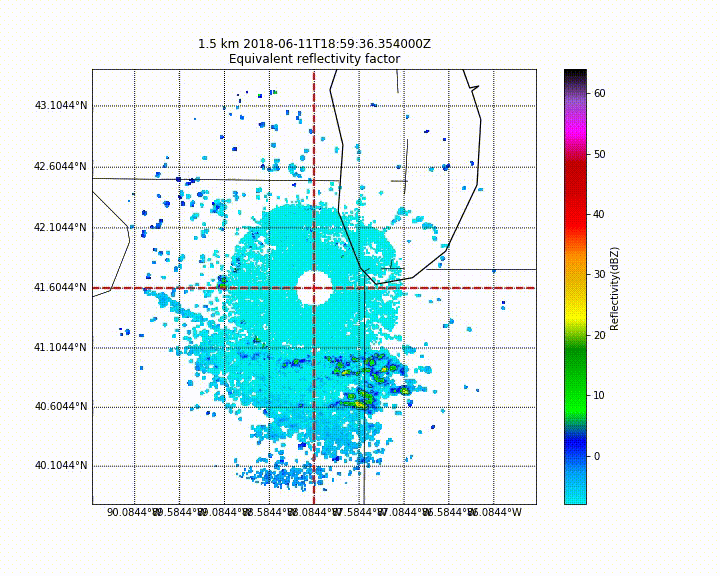

In [30]:
embed_mp4_as_gif(out_dir_path + '/test_animation.mp4')